goal : predicts if pair's 1st digit <= to the second (=0) or if pair's 1st digit > to the second (=1)

Ideas of architectures to test :
- Simple MLP (fully connected)
- LetNet5
- AlexNet
- VGGNet19
- Residual Net
- Use cross entropy
- Use dropout

General framework to test :
- Network is trained to predict directly lesser or greater
- Network is trained to predict number, then we do the difference

In this notebook we explore the first architecture only

## Dataset

In [1]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import dlc_practical_prologue as prologue
from torch.optim.lr_scheduler import MultiStepLR

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Datas(Dataset):
    
    def __init__(self, train_input, train_target):
        
        self.train_input = train_input
        self.train_target = train_target

    def __len__(self):
        return len(self.train_input)

    def __getitem__(self, idx):
        return {'train': self.train_input[idx], 'target': self.train_target[idx]}

In [3]:
def hot_encode(data): # Not used in the code for classification and then comparaison
    """ 2-class hot encoding of target """
    col_view = data.view(-1,1)
    return torch.cat((col_view == 0, col_view == 1), dim=1).float()

In [4]:
N = 1000
# Load data
#train_input, train_target, _ , test_input, test_target, _ = prologue.generate_pair_sets(N)
train_input, train_target_final, train_classes, test_input, test_target_final,test_classes = prologue.generate_pair_sets(N)

In [5]:
train_binary_classes = torch.full((2*N,10), 0)
test_binary_classes = torch.full((2*N, 10), 0)
train_binary_classes.scatter_(1,train_classes.reshape((2*N, 1)), 1)
test_binary_classes.scatter_(1,test_classes.reshape((2*N, 1)), 1)
train_input, train_target = train_input.reshape((2*N, 14*14)), train_binary_classes
test_input, test_target = test_input.reshape((2*N, 14*14)), test_binary_classes

## Normalize

In [15]:
def normalization(train_input,test_input):
    """The input data is normalized. This function modifies the input data"""
    mu = train_input.mean(dim=0)
    std = train_input.std(dim=0)
    train_input.sub_(mu).div_(std+1)
    test_input.sub_(mu).div_(std+1)

In [16]:
normalization(train_input,test_input)

""""mu = train_input.mean(dim=0)
std = train_input.std(dim=0)
train_input.sub_(mu).div_(std+1)
test_input.sub_(mu).div_(std+1)
"""

'"mu = train_input.mean(dim=0)\nstd = train_input.std(dim=0)\ntrain_input.sub_(mu).div_(std+1)\ntest_input.sub_(mu).div_(std+1)\n'

## Models

In [8]:
class MLP(nn.Module):
    
    """ A multilayer perceptron (i.e fully connected layers only) of L hidden 
    layers of with h hidden neurons per layer """
    
    def __init__(self, L, h):
        super(MLP, self).__init__()
        # (N, 196 (=14*14)) -> (N, h)
        self.in_layer = nn.Linear(196, h)
        # (N, h) -> (N, h) -> ... -> (N, h)
        hidden_layers = []
        for l in range(L):
            hidden_layers.append(nn.LeakyReLU())
            #hidden_layers.append(nn.Dropout(0.5))
            hidden_layers.append(nn.Linear(h,h))
        hidden_layers.append(nn.LeakyReLU())
        
        self.hidden_layers = nn.Sequential(*hidden_layers)
        # (N, h) -> (N, 10)
        self.out_layer = nn.Linear(h, 10)
        
    def forward(self, x):
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # MLP net
        x = self.in_layer(x)
        x = self.hidden_layers(x)
        x = self.out_layer(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = self.fc2(x)
        return x

    
class LeNet5Like(nn.Module):
    
    """ Modified LeNet5 (adapted to have 14*14 inputs & ouptut size 10) """
    
    def __init__(self, dropout=False):
        super(LeNet5Like, self).__init__()
        self.features = nn.Sequential(
              # (N, 1, 14, 14) -> (N, 8, 10, 10)
              nn.Conv2d(1, 8, kernel_size=3),
              nn.ReLU(),
              # (N, 8, 10, 10) -> (N, 8, 5, 5)
              nn.MaxPool2d(kernel_size=2, stride=2),
              # (N, 8, 5, 5) -> (N, 16, 1, 1)
              nn.Conv2d(8, 16, kernel_size=3),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2),
              nn.ReLU()
          )  
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 64) -> (N, 20)
                  nn.Linear(64, 20),
                  nn.ReLU(),
                  nn.Dropout(0.1),
                  # (N, 20) -> (N, 10)
                  nn.Linear(20, 10),
              )
        else :
            self.classifier = nn.Sequential(
                   # (N, 64) -> (N, 20)
                  nn.Linear(64, 20),
                  nn.ReLU(),
                  # (N, 20) -> (N, 10)
                  nn.Linear(20, 10),
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x
    
    
class VGGNetLike(nn.Module):
    
    """ Inspired from VGGNet, adapted to have 14*14 inputs & ouptut size 2) """
    
    def __init__(self, dropout):
        super(VGGNetLike, self).__init__()
        layers = []
        # We start from 14*14 pictures padded to 16*16 and divide the 
        # dimension by two while multiplying the channel count by two 
        # at each block
        layers.append(nn.ConstantPad2d(1, 0))
        for l in range(4):
            # We go to 64 channels and multiply by 2 the number of
            # channel at each block (like in original VGGNet) 
            channels_count = 2**(6+l)
            prev_channels_count = 1 if (l == 0) else 2**(6+(l-1))
            print((prev_channels_count, channels_count))
            layers.append(nn.Conv2d(prev_channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            #layers.append(nn.Conv2d(channels_count, channels_count, kernel_size=3, padding=1))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))   
        self.features = nn.Sequential(*layers)
        # Classifier with fully connected layers
        if dropout :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  nn.Dropout(0.5),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 10)
              )
        else :
            self.classifier = nn.Sequential(
                  # (N, 512) -> (N, 128)
                  nn.Linear(512, 128),
                  nn.ReLU(),
                  # (N, 128) -> (N, 64)
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  # (N, 64) -> (N, 2)
                  nn.Linear(64, 10)
              )
        
    def forward(self, x):
        # Feature block
        x = self.features(x)
        # Flatten to vector before linear layers
        x = x.view(x.size(0), -1)
        # Classifier block
        x = self.classifier(x)
        return x

class ResBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size,padding = (kernel_size-1)//2)
        self.bn1 = nn.BatchNorm2d(nb_channels)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size,padding = (kernel_size-1)//2)
        self.bn2 = nn.BatchNorm2d(nb_channels)
    def forward(self, x):
        y = self.bn1(self.conv1(x))
        y = F.relu(y)
        y = self.bn2(self.conv2(y))
        y += x
        y = F.relu(y)
        return y
class ResNet(nn.Module):
    def __init__(self, nb_channels, kernel_size, nb_blocks):
        super(ResNet, self).__init__()
        self.conv0 = nn.Conv2d(1, nb_channels, kernel_size = 1)
        self.resblocks = nn.Sequential(
            # A bit of fancy Python
            *(ResBlock(nb_channels, kernel_size) for _ in range(nb_blocks)))
        self.avg = nn.AvgPool2d(kernel_size = 14)
        self.fc = nn.Linear(nb_channels, 10)
    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = self.resblocks(x)
        x = F.relu(self.avg(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## Train and test

In [9]:
def compute_errors(output, target):
    """ Computes error percentage given output and target"""
    errors_amount = (output.argmax(dim=1) != target.argmax(dim=1)).sum().item()
    return (errors_amount / output.shape[0]) * 100
def compute_errors2(output,target):
    errors_amount = (output.argmax(dim=1) != target).sum().item()
    return (errors_amount / output.shape[0]) * 100

In [10]:
def compute_errors_final(output,target_final):
    output_N2 = torch.argmax(output,dim=1).reshape(-1,2)
    bigger_output = torch.argmax(output_N2,dim=1)
    errors_amount = (bigger_output!=target_final).sum().item()
    return (errors_amount/output_N2.shape[0])*100

In [24]:
def train(model, train_input, train_target, test_input, test_target,test_target_final) :
    
    lr = 1e-3
    batch_size = 100
    epochs = 200
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    criterion = nn.MSELoss()
    
    train_errors = []
    train_errors_final = []
    test_errors = []
    test_errors_final = []
    
    for e in range(epochs):
        #print("Epoch: {}".format(e))
        print('.', end='')
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            train_target_batch = train_target.narrow(0, b, batch_size)
            loss = criterion(output, train_target_batch)
            #print(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            # Compute train error
            output_train = model(train_input)
            train_errors.append(compute_errors(output_train, train_target))
            # Compute the train smaller/bigger prediction
            train_errors_final.append(compute_errors_final(output_train,train_target_final))
            # Compute test error
            output_test = model(test_input)
            if (e == 199):
                print(output_test)
            test_errors.append(compute_errors(output_test, test_target))
            # Compute the test smaller/bigger prediction
            test_errors_final.append(compute_errors_final(output_test,test_target_final))
                
    return train_errors, test_errors, train_errors_final,test_errors_final

In [57]:
def train2(model, train_input, train_target, test_input, test_target,test_target_final,criteria=nn.MSELoss()) :
    
    lr = 1e-3
    batch_size = 100
    epochs = 200
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    criterion = criteria
    
    print(criterion)
    
    train_errors = []
    train_errors_final = []
    test_errors = []
    test_errors_final = []
    
    scheduler = MultiStepLR(optimizer, milestones=[10,200], gamma=0.1)
    
    for e in range(epochs):
        #scheduler.step()
        #("Epoch: {}".format(e))
        print('.', end='')
        for b in range(0, train_input.size(0), batch_size):
            output = model(train_input.narrow(0, b, batch_size))
            train_target_batch = train_target.narrow(0, b, batch_size)
            loss = criterion(output, train_target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            # Compute train error
            output_train = model(train_input)
            if (criterion == MSELoss()):
                print("ggg")
                train_errors.append(compute_errors(output_train, train_target))
            else:
                train_errors.append(compute_errors2(output_train, train_target))
            # Compute test error
            output_test = model(test_input)
            if (e == 199):
                print(output_test[0])
                print(test_target[0])
                print(output_test[1])
                print(test_target[1])
                print(output_test[2])
                print(test_target[2])
            if (criterion == nn.MSELoss()):
                test_errors.append(compute_errors(output_test, test_target))
            else:
                test_errors.append(compute_errors2(output_test, test_target))
            # Compute the test smaller/bigger prediction
            test_errors_final.append(compute_errors_final(output_test,test_target_final))
                
    return train_errors, test_errors, train_errors_final,test_errors_final

In [58]:
def plot_errors(train_errors, test_errors, title,ylim = 100):
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('error %')
    plt.plot(train_errors, label='train error %')
    plt.plot(test_errors, label='test error %')
    plt.ylim(0, ylim)
    plt.legend()
    plt.grid()
    plt.show()

........................................................................................................................................................................................................tensor([[ 0.0973,  0.1059, -0.0144,  ...,  0.1264,  0.1026,  0.1414],
        [ 0.0971,  0.0848, -0.0306,  ...,  0.1368,  0.1030,  0.1634],
        [ 0.0971,  0.0854, -0.0302,  ...,  0.1365,  0.1030,  0.1629],
        ...,
        [ 0.0977,  0.1479,  0.0190,  ...,  0.1057,  0.1015,  0.0972],
        [ 0.0970,  0.0806, -0.0342,  ...,  0.1389,  0.1032,  0.1680],
        [ 0.0971,  0.0874, -0.0285,  ...,  0.1355,  0.1030,  0.1607]])


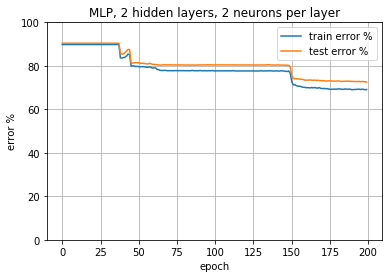

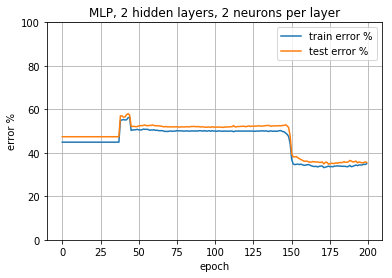

........................................................................................................................................................................................................tensor([[ 0.1828, -0.0456,  0.2127,  ...,  0.0103,  0.1740,  0.0328],
        [ 0.0265,  0.0018,  0.0235,  ...,  0.4504,  0.0121,  0.3897],
        [-0.1158,  0.1045, -0.1308,  ...,  0.1252, -0.1504,  0.1355],
        ...,
        [ 0.0787, -0.0293,  0.0964,  ..., -0.1006,  0.0530, -0.0493],
        [-0.0345,  0.0413, -0.0491,  ...,  0.5771, -0.0506,  0.4921],
        [ 0.0388, -0.0154,  0.0430,  ...,  0.2275,  0.0189,  0.2129]])


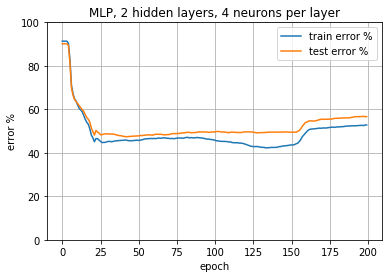

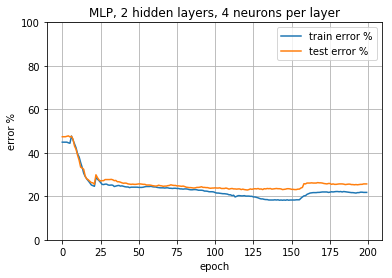

........................................................................................................................................................................................................tensor([[ 8.9797e-01,  2.2766e-02, -1.4797e-03,  ..., -1.5632e-03,
         -6.9238e-03, -3.2148e-04],
        [-4.8922e-02, -3.8011e-03, -1.7710e-03,  ...,  4.8520e-01,
         -4.2539e-03,  6.4406e-01],
        [ 7.4654e-02, -4.3753e-03,  8.4020e-04,  ...,  2.9147e-02,
         -1.3818e-01, -7.7421e-02],
        ...,
        [ 2.8710e-02,  8.6324e-03, -5.8402e-03,  ..., -3.9561e-02,
          7.6645e-02, -1.1846e-01],
        [ 8.5694e-03,  9.5648e-04, -8.2811e-03,  ...,  9.9050e-01,
          1.4520e-02, -1.6094e-03],
        [ 4.5706e-03,  2.8220e-03,  2.0061e-03,  ..., -2.3810e-02,
          2.2204e-02, -2.0949e-02]])


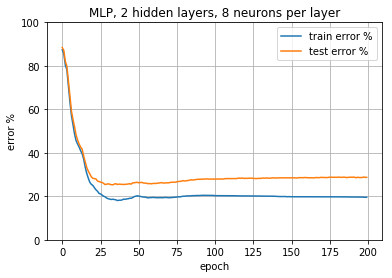

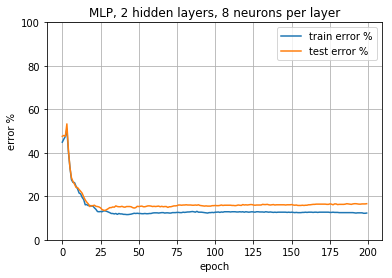

........................................................................................................................................................................................................tensor([[ 0.0882,  0.1202,  0.1141,  ...,  0.0936,  0.0890,  0.0937],
        [ 0.0657,  0.1787,  0.0066,  ...,  0.1351,  0.1097,  0.1400],
        [ 0.0658,  0.1786,  0.0067,  ...,  0.1351,  0.1097,  0.1399],
        ...,
        [ 0.0577,  0.2000, -0.0328,  ...,  0.1499,  0.1171,  0.1570],
        [ 0.0642,  0.1828, -0.0010,  ...,  0.1380,  0.1111,  0.1432],
        [ 0.0661,  0.1778,  0.0082,  ...,  0.1345,  0.1094,  0.1393]])


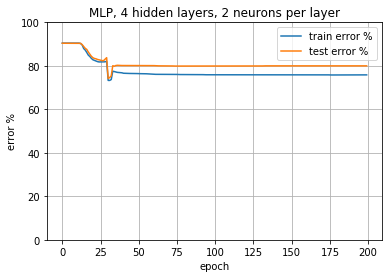

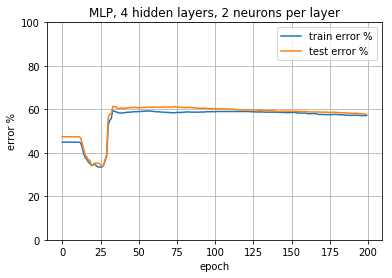

........................................................................................................................................................................................................tensor([[ 0.1905, -0.0187,  0.0040,  ...,  0.0628,  0.1826,  0.2052],
        [ 0.2031, -0.0188,  0.0041,  ...,  0.0486,  0.1930,  0.2176],
        [ 0.0260, -0.0118,  0.0027,  ...,  0.2471,  0.0460,  0.0426],
        ...,
        [-0.0243,  0.8059,  0.0178,  ..., -0.0010, -0.0091, -0.0174],
        [ 0.0260, -0.0119,  0.0027,  ...,  0.2470,  0.0460,  0.0426],
        [ 0.0934,  0.4609,  0.0090,  ..., -0.0086,  0.0891,  0.0995]])


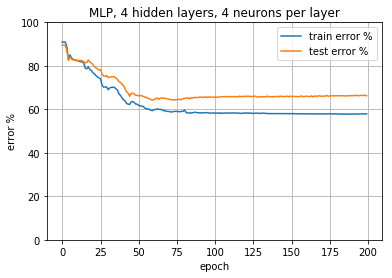

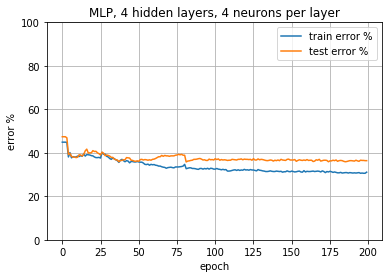

........................................................................................................................................................................................................tensor([[ 2.6055e-01, -7.1288e-02,  2.7494e-01,  ..., -1.3128e-02,
          1.9189e-01,  4.6857e-03],
        [-2.9426e-02, -1.7673e-02, -2.3601e-02,  ...,  5.3649e-01,
         -1.4614e-02,  5.2957e-01],
        [-6.4832e-02, -2.7547e-01, -3.2688e-02,  ...,  4.0478e-01,
         -4.5188e-02, -1.0613e+00],
        ...,
        [ 2.5266e-02, -4.8556e-02,  6.4211e-03,  ...,  9.2152e-03,
         -5.3551e-03, -1.3888e-03],
        [-1.4214e-02, -1.1918e-02,  7.2115e-04,  ...,  1.0016e+00,
          1.1381e-02,  2.6753e-03],
        [ 3.4675e-03, -4.8506e-02,  1.3710e-02,  ...,  3.6851e-03,
          3.8661e-04,  3.7187e-02]])


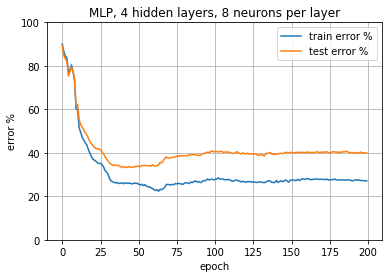

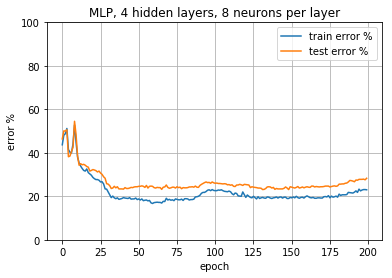

........................................................................................................................................................................................................tensor([[ 1.4611e-01, -7.7643e-02,  1.5002e-01,  ..., -1.6876e-02,
          1.4290e-01,  8.1430e-03],
        [-3.6548e-05,  4.3231e-02, -7.7472e-03,  ...,  4.7338e-01,
          1.3418e-03,  5.0535e-01],
        [ 1.3624e-01, -2.6226e-02,  1.4440e-01,  ..., -5.9305e-03,
          1.3494e-01,  9.1776e-03],
        ...,
        [ 1.3181e-01, -3.1390e-03,  1.4187e-01,  ..., -1.0157e-03,
          1.3137e-01,  9.6422e-03],
        [-3.6525e-05,  4.3231e-02, -7.7471e-03,  ...,  4.7338e-01,
          1.3418e-03,  5.0535e-01],
        [ 1.2812e-01,  1.6050e-02,  1.3978e-01,  ...,  3.0694e-03,
          1.2840e-01,  1.0028e-02]])


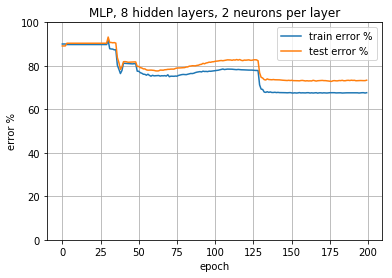

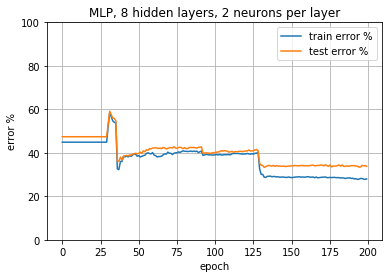

........................................................................................................................................................................................................tensor([[0.0994, 0.0038, 0.1964,  ..., 0.1177, 0.0903, 0.0895],
        [0.0995, 0.0039, 0.1455,  ..., 0.1142, 0.0979, 0.1043],
        [0.0996, 0.0042, 0.0323,  ..., 0.1065, 0.1149, 0.1371],
        ...,
        [0.0992, 0.0033, 0.3795,  ..., 0.1303, 0.0628, 0.0363],
        [0.0995, 0.0040, 0.0918,  ..., 0.1106, 0.1060, 0.1198],
        [0.0996, 0.0041, 0.0506,  ..., 0.1078, 0.1122, 0.1318]])


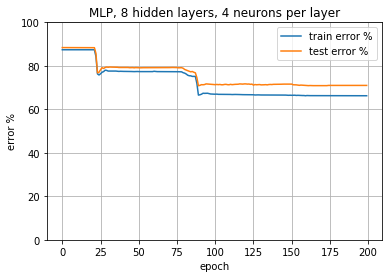

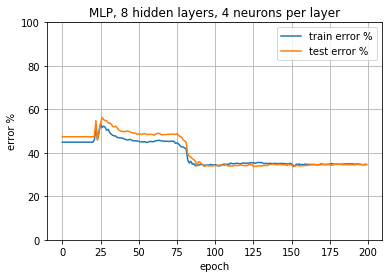

........................................................................................................................................................................................................tensor([[ 3.6196e-01,  7.3948e-03,  1.4565e-02,  ...,  2.1077e-01,
          2.7625e-01, -1.4530e-01],
        [-3.5633e-02,  1.0496e-02,  1.2577e-02,  ...,  3.4540e-01,
          1.7349e-02,  6.3573e-01],
        [-5.0764e-03,  2.2940e-02,  3.9592e-02,  ...,  7.1767e-03,
         -7.6169e-03, -3.0423e-03],
        ...,
        [ 1.0242e-02,  6.2366e-03,  1.3624e-02,  ..., -6.4268e-03,
          9.5358e-04, -3.5676e-03],
        [ 1.9955e-01, -2.5208e-03,  1.7847e-02,  ...,  9.2582e-01,
         -1.1106e-01,  9.6697e-02],
        [-5.6275e-03,  1.4755e-02, -2.3963e-03,  ...,  6.9558e-03,
         -6.4399e-03,  5.8846e-04]])


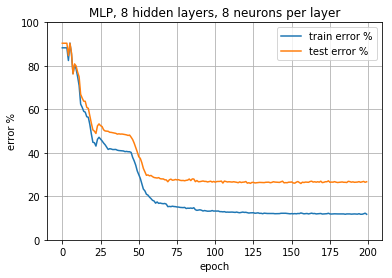

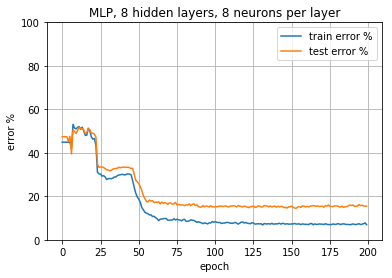

In [60]:
# MLP Models
for L in [2, 4, 8] :
    for h in [2, 4, 8] :
        model = MLP(L, h)
        train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target, test_target_final)
        plot_errors(train_errors, test_errors, 'MLP, {} hidden layers, {} neurons per layer'.format(L,h))
        plot_errors(train_errors_final, test_errors_final, 'MLP, {} hidden layers, {} neurons per layer'.format(L,h))
        del model

In [33]:
# Reshape the datas
train_input = train_input.reshape((2*N,1,14,14))
test_input = test_input.reshape((2*N,1,14,14))

........................................................................................................................................................................................................tensor([[ 1.1534,  0.0609,  0.0288,  ..., -0.0308, -0.0421,  0.0049],
        [-0.0392, -0.1418, -0.0117,  ...,  1.0086,  0.1336,  0.0174],
        [-0.0113, -0.0522,  0.0262,  ..., -0.0076,  0.1146, -0.0292],
        ...,
        [ 0.0536,  0.0136,  0.0090,  ...,  0.0102,  0.0445, -0.0113],
        [-0.0572, -0.0585, -0.0140,  ...,  1.1138,  0.0563, -0.0440],
        [ 0.0121,  0.0129,  0.0301,  ..., -0.0165, -0.0723,  0.0154]])


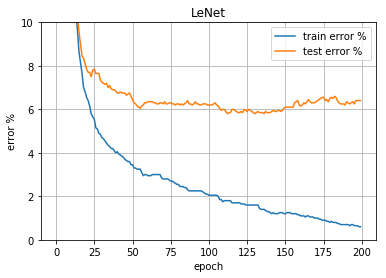

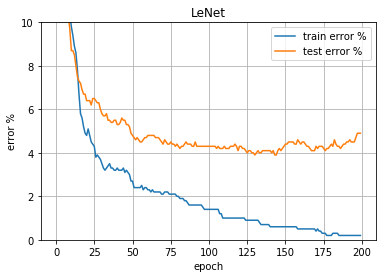

In [34]:
model = Net()
train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
plot_errors(train_errors, test_errors, 'LeNet',10)
plot_errors(train_errors_final, test_errors_final, 'LeNet',10)
del model

........................................................................................................................................................................................................tensor([[ 1.0377,  0.0719,  0.0319,  ..., -0.0560,  0.0141, -0.0098],
        [ 0.0105, -0.0381, -0.0214,  ...,  0.8306,  0.0099,  0.2096],
        [ 0.2473, -0.0185, -0.0290,  ...,  0.0177,  0.0180, -0.0241],
        ...,
        [ 0.0988, -0.0117,  0.0820,  ...,  0.0283,  0.0115, -0.1226],
        [ 0.0164,  0.0067,  0.0085,  ...,  0.9014, -0.0122, -0.0070],
        [-0.0044,  0.0162, -0.0189,  ..., -0.0728, -0.0205,  0.1594]])


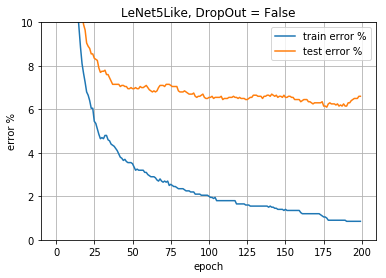

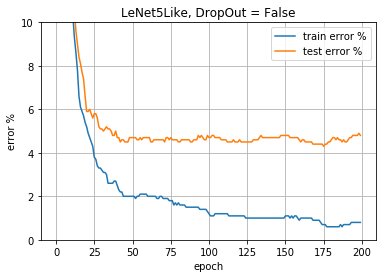

........................................................................................................................................................................................................tensor([[ 1.3469e+00, -6.3726e-02, -6.0653e-02,  ..., -3.9125e-02,
         -4.3868e-02,  9.7301e-02],
        [-5.5202e-02, -3.5702e-03, -6.7457e-02,  ...,  7.6649e-01,
         -9.2202e-03,  3.6089e-01],
        [-2.5432e-03, -1.9187e-03, -6.3364e-03,  ..., -6.9499e-03,
         -3.1804e-04, -6.2778e-03],
        ...,
        [ 5.9193e-03,  2.2399e-02,  9.7295e-03,  ...,  5.3245e-03,
          9.4427e-03,  9.4690e-03],
        [-1.3866e-02,  3.9885e-02, -3.0393e-02,  ...,  9.1976e-01,
          2.1864e-02, -3.7199e-03],
        [ 4.4231e-03,  1.2522e-02,  4.5452e-03,  ...,  2.4839e-03,
          8.4312e-03,  1.9295e-03]])


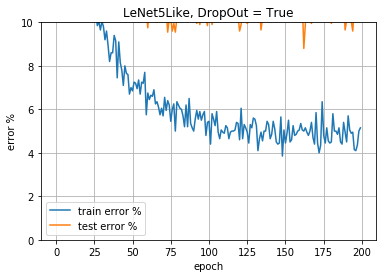

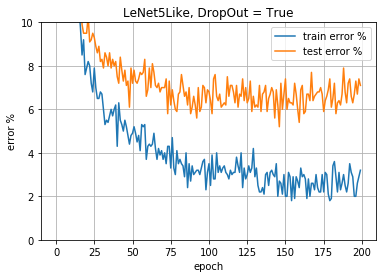

In [28]:
# LeNet5 Model
for dropout in [False]#[False, True] :
    model = LeNet5Like(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
    plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    del model

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
........................................................................................................................................................................................................tensor([ 35.2134, -15.8419,  -2.9616, -18.9263, -41.6335,   0.2163,   6.1129,
        -13.9273,  -1.5212, -25.0529])
tensor(0)
tensor([-22.2987, -16.2500,   4.3147,  15.2189, -61.4172, -17.8526, -71.6630,
         35.8639,  -7.4799,   7.1440])
tensor(7)
tensor([ -5.7944, -10.8801, -13.9495, -25.6785,  27.5785, -10.2980,   3.2361,
         -9.5205,  -3.6766,   2.1534])
tensor(4)


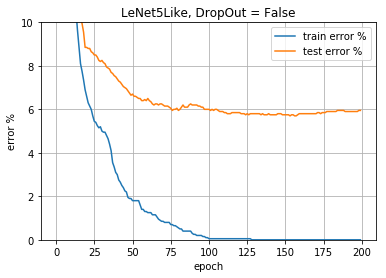

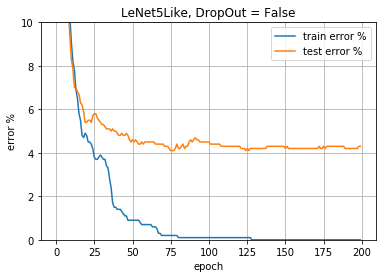

In [45]:
# LeNet5 Model with CrossEntropy
print(test_target)
for dropout in [False]:#[False, True] :
    model = LeNet5Like(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train2(model, train_input, train_classes.reshape(2*N), test_input, test_classes.reshape(2*N),test_target_final,nn.CrossEntropyLoss())
    plot_errors(train_errors, test_errors, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'LeNet5Like, DropOut = {}'.format(dropout),10)
    del model

(1, 64)
(64, 128)
(128, 256)
(256, 512)
........................................................................................................................................................................................................

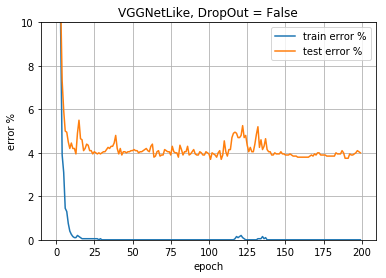

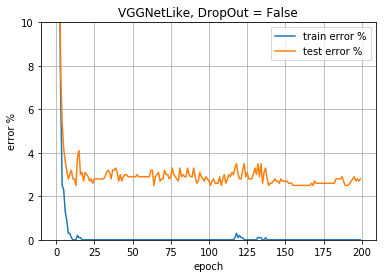

(1, 64)
(64, 128)
(128, 256)
(256, 512)
........................................................................................................................................................................................................

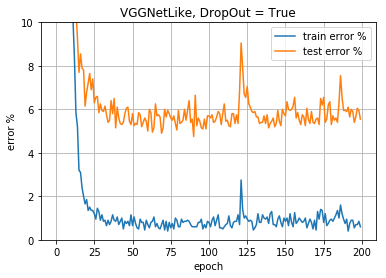

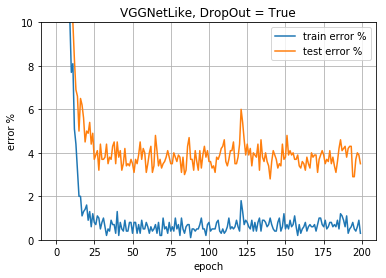

In [22]:
# VGGNet Model
for dropout in [False, True] :
    model = VGGNetLike(dropout=dropout)
    train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
    plot_errors(train_errors, test_errors, 'VGGNetLike, DropOut = {}'.format(dropout),10)
    plot_errors(train_errors_final, test_errors_final, 'VGGNetLike, DropOut = {}'.format(dropout),10)
    del model

........................................................................................................................................................................................................

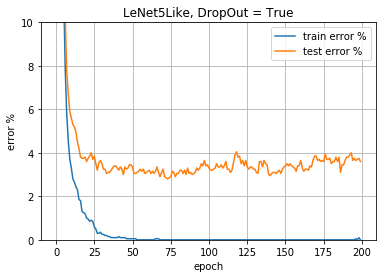

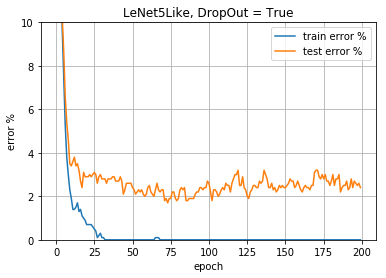

In [48]:
# ResNet 3x3, 5 blocks, 16 channels
nb_channels = 16
kernel_size = 3
nb_blocks = 5
model = ResNet(nb_channels = nb_channels, kernel_size = kernel_size, nb_blocks = nb_blocks)
train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
plot_errors(train_errors, test_errors, 'ResNetLike, DropOut = {}'.format(dropout),10)
plot_errors(train_errors_final, test_errors_final, 'ResLike, DropOut = {}'.format(dropout),10)

........................................................................................................................................................................................................

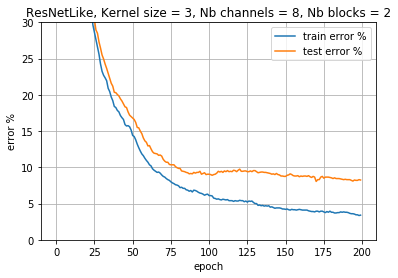

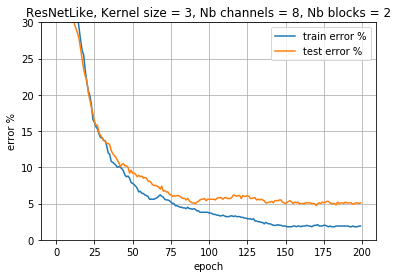

........................................................................................................................................................................................................

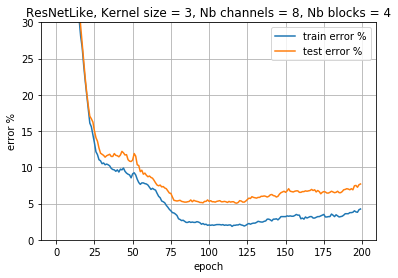

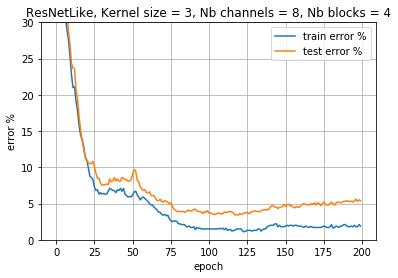

........................................................................................................................................................................................................

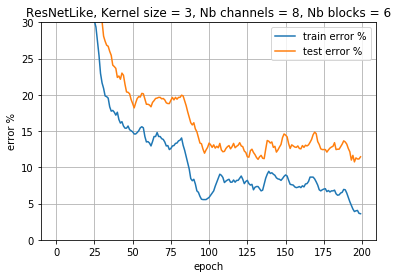

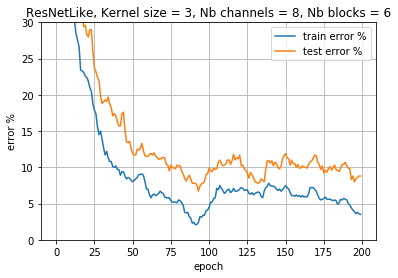

........................................................................................................................................................................................................

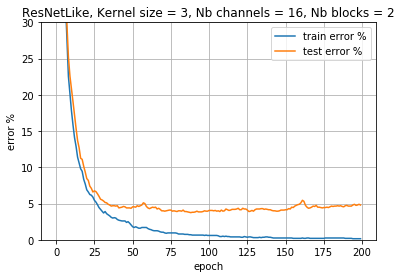

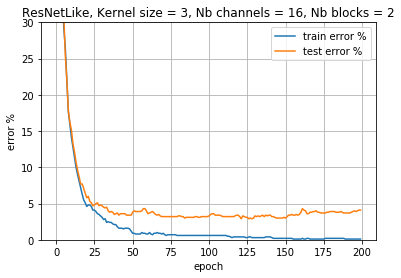

........................................................................................................................................................................................................

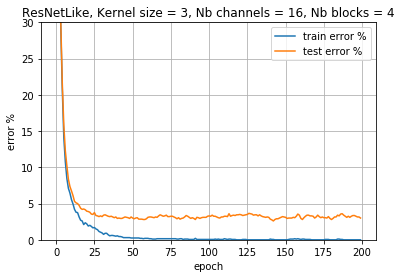

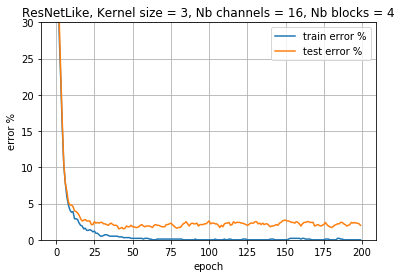

........................................................................................................................................................................................................

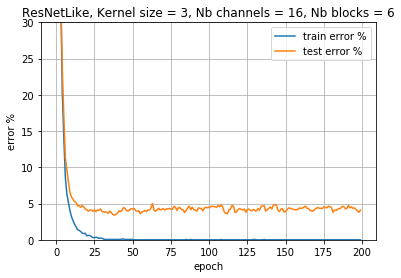

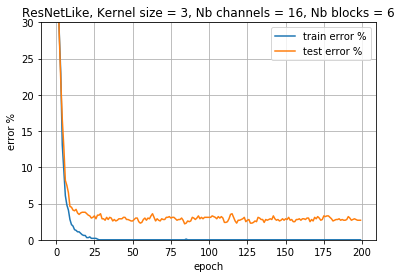

........................................................................................................................................................................................................

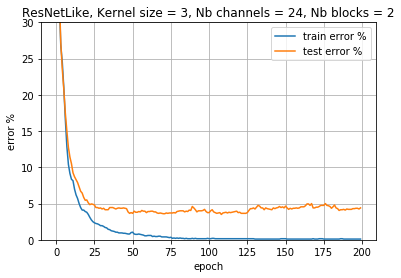

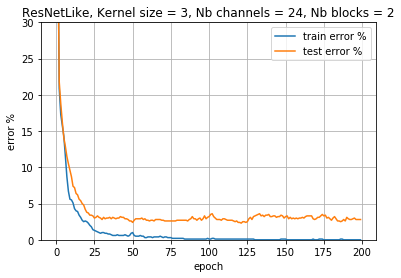

........................................................................................................................................................................................................

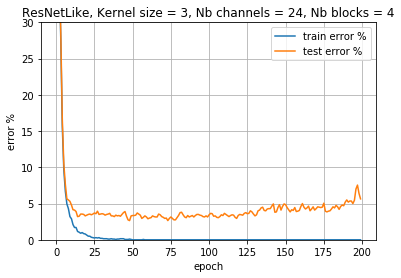

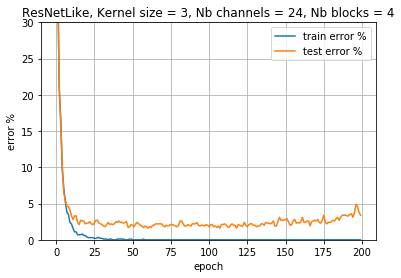

........................................................................................................................................................................................................

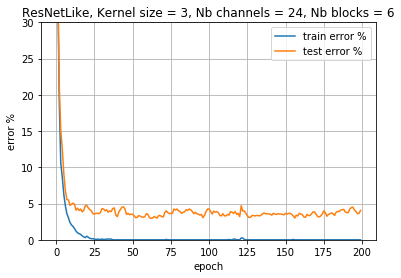

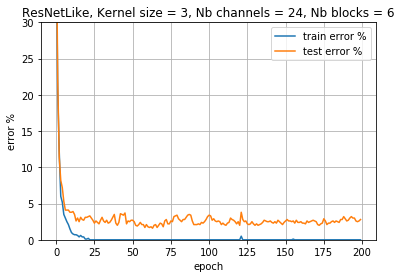

........................................................................................................................................................................................................

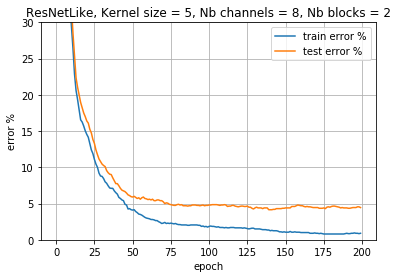

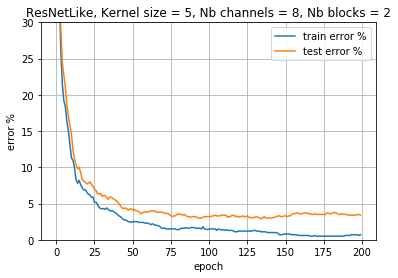

........................................................................................................................................................................................................

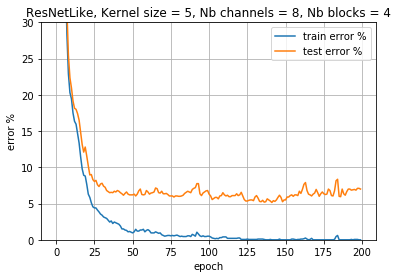

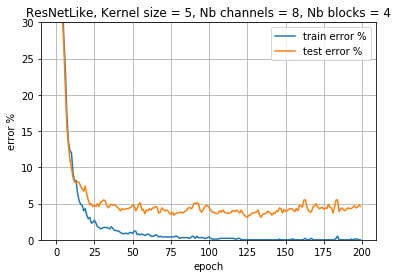

........................................................................................................................................................................................................

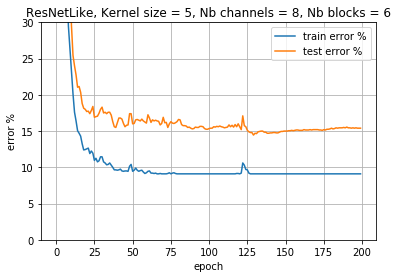

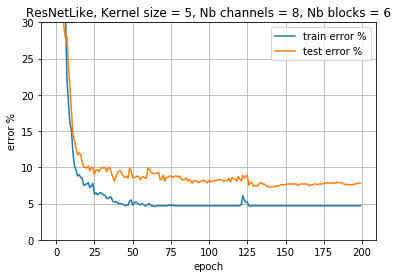

........................................................................................................................................................................................................

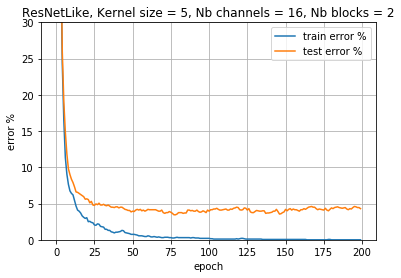

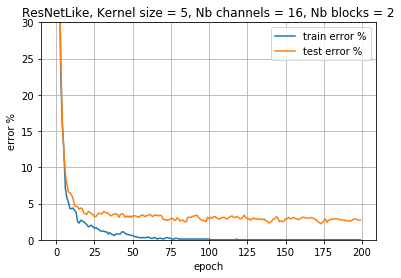

........................................................................................................................................................................................................

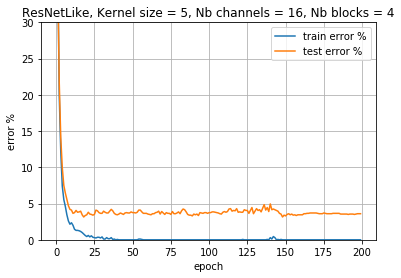

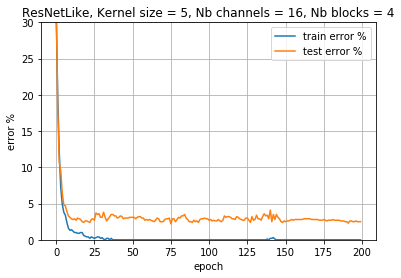

........................................................................................................................................................................................................

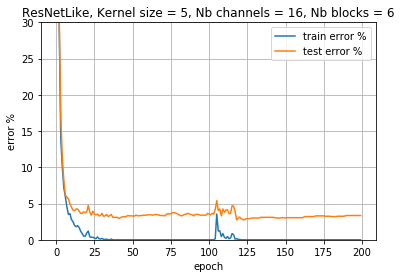

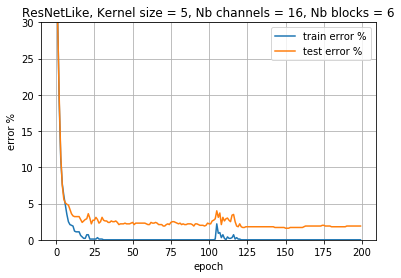

........................................................................................................................................................................................................

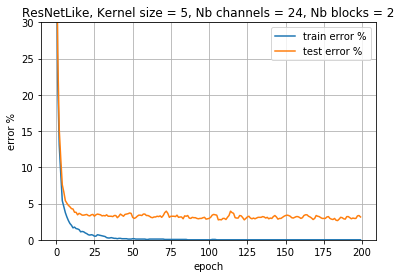

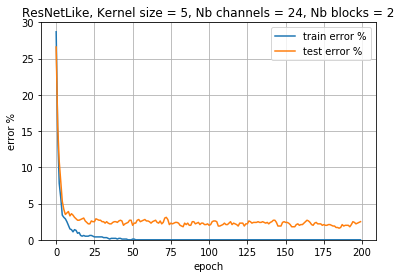

........................................................................................................................................................................................................

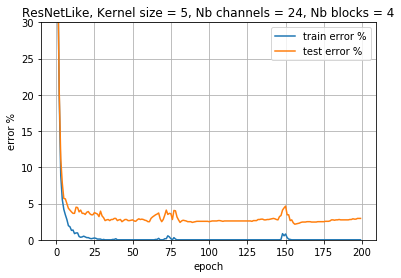

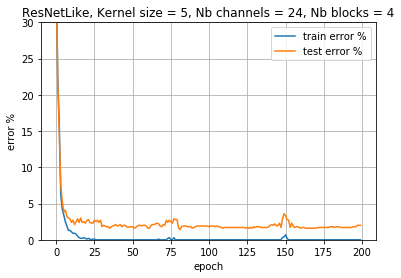

........................................................................................................................................................................................................

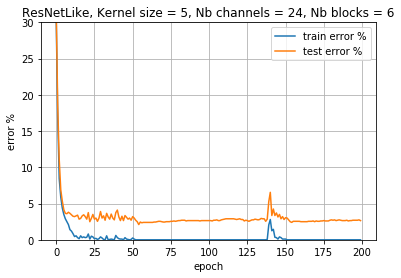

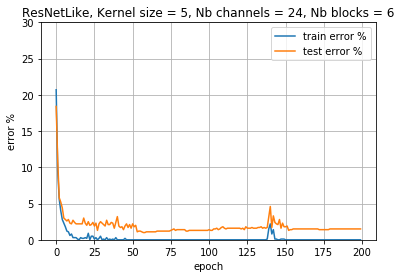

........................................................................................................................................................................................................

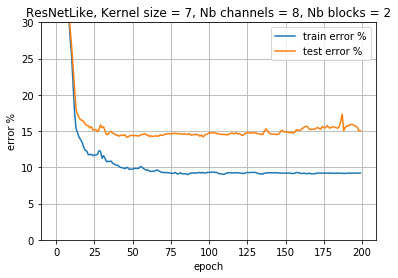

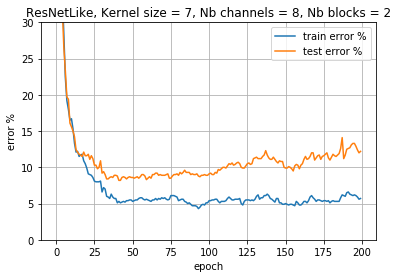

........................................................................................................................................................................................................

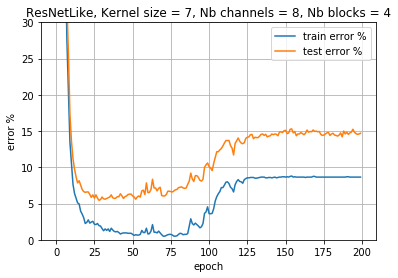

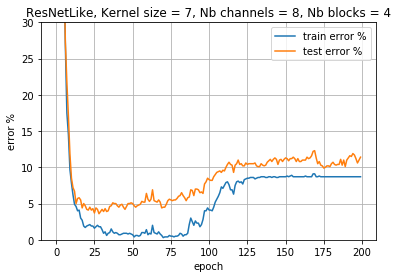

........................................................................................................................................................................................................

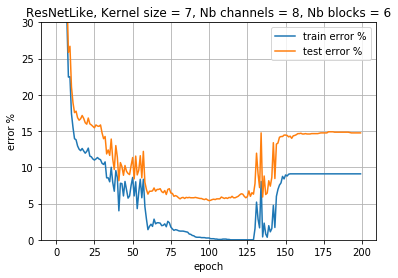

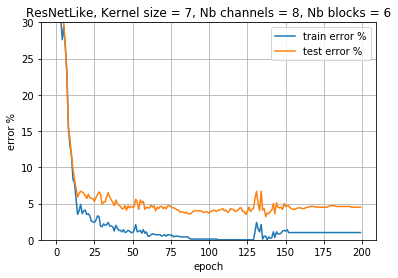

........................................................................................................................................................................................................

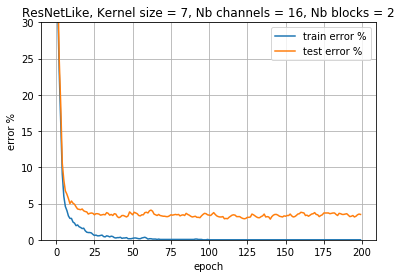

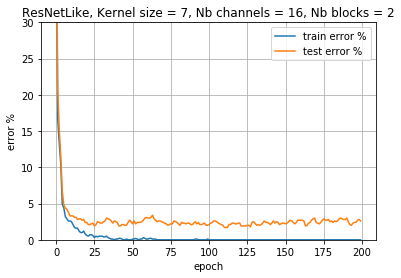

........................................................................................................................................................................................................

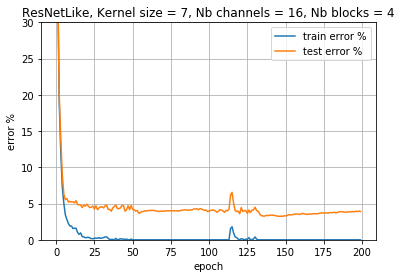

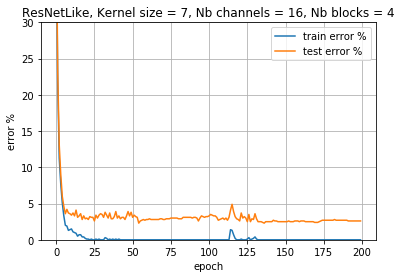

........................................................................................................................................................................................................

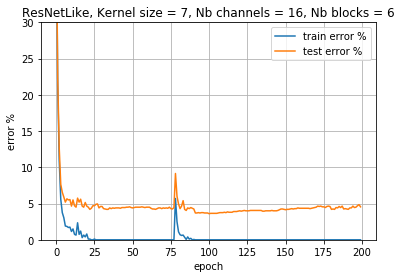

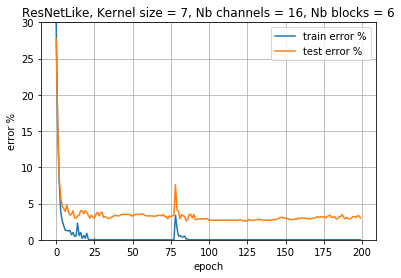

........................................................................................................................................................................................................

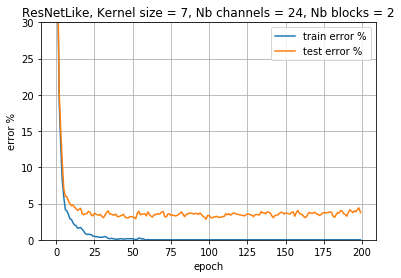

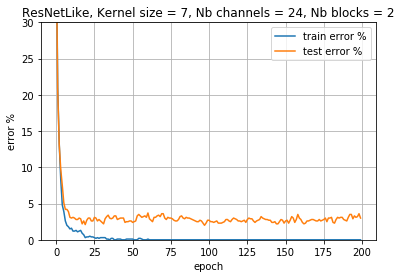

...............................................................................................................

In [ ]:
# ResNet 
for kernel_size in [3,5,7]:
    for nb_channels in [8,16,24]:
        for nb_blocks in [2,4,6]:
            model = ResNet(nb_channels = nb_channels, kernel_size = kernel_size, nb_blocks = nb_blocks)
            train_errors, test_errors, train_errors_final, test_errors_final = train(model, train_input, train_target, test_input, test_target,test_target_final)
            plot_errors(train_errors, test_errors, 'ResNetLike, Kernel size = {}, Nb channels = {}, Nb blocks = {}'.format(kernel_size, nb_channels, nb_blocks),30)
            plot_errors(train_errors_final, test_errors_final, 'ResNetLike, Kernel size = {}, Nb channels = {}, Nb blocks = {}'.format(kernel_size, nb_channels, nb_blocks),30)